In [1]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from IPython.display import Audio, display

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# List of classes to use
CLASSES = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]



Using device: cuda


In [2]:
# Helper to filter dataset by class
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        custom_path = r"D:\Python Projects\Envision Project\Dataset\speech_commands_v0.02"
        if os.path.exists(custom_path):
            print(f"Using dataset found at: {custom_path}")
            root = r"D:\Python Projects\Envision Project\Dataset"
            download = False
        else:
            print("Dataset not found at custom path, downloading to default location...")
            root = "./"
            download = True
        super().__init__(root=root, download=download)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in f]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

# Load datasets
try:
    train_set = SubsetSC("training")
    val_set = SubsetSC("validation")
    test_set = SubsetSC("testing")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Attempting to download dataset to default location...")
    train_set = SubsetSC("training")
    val_set = SubsetSC("validation")
    test_set = SubsetSC("testing")
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")



Dataset not found at custom path, downloading to default location...


100%|██████████| 2.26G/2.26G [01:44<00:00, 23.3MB/s]


Dataset not found at custom path, downloading to default location...
Dataset not found at custom path, downloading to default location...
Train set size: 84843
Validation set size: 9981


Sample rate: 16000
Waveform shape: torch.Size([1, 16000])
Label: down


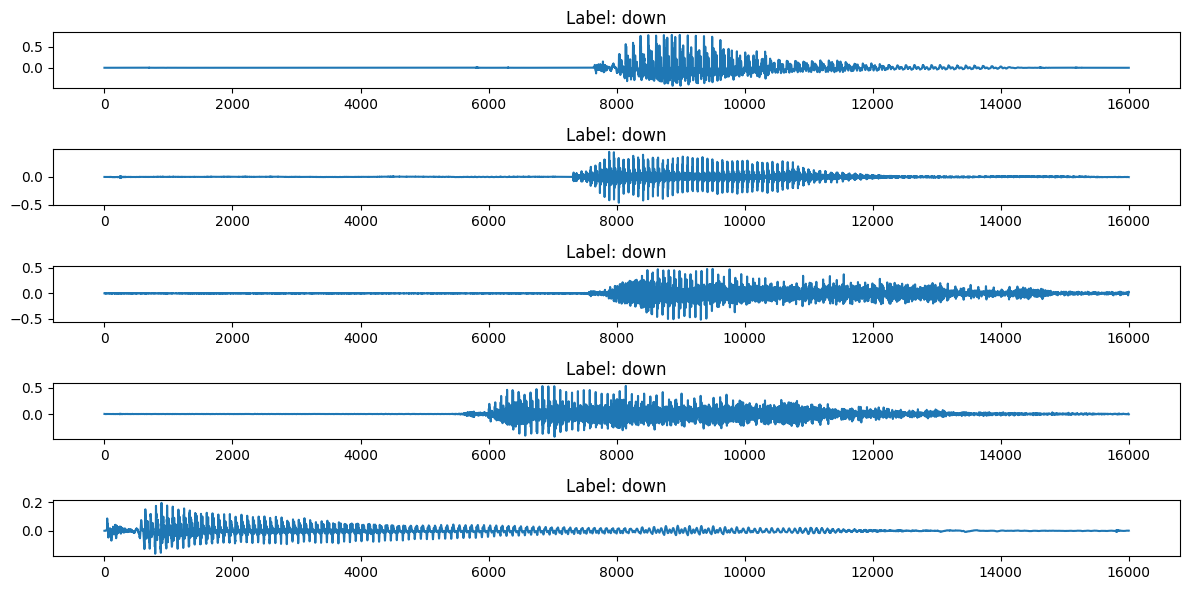

Label: down


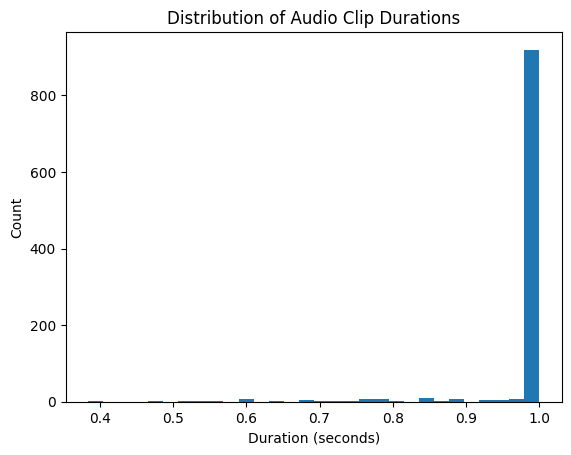

Min duration: 0.38s, Max duration: 1.00s, Mean: 0.98s


In [3]:
# Filter samples to only include selected classes
def filter_classes(dataset, classes):
    indices = []
    for idx in range(len(dataset)):
        _, _, label, *_ = dataset[idx]
        if label in classes:
            indices.append(idx)
    return indices

train_indices = filter_classes(train_set, CLASSES)
val_indices = filter_classes(val_set, CLASSES)
test_indices = filter_classes(test_set, CLASSES)

# Check one sample
sample_waveform, sample_sr, sample_label, *_ = train_set[train_indices[0]]
print("Sample rate:", sample_sr)
print("Waveform shape:", sample_waveform.shape)
print("Label:", sample_label)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(train_indices[:5]):
    waveform, sr, label, *_ = train_set[idx]
    plt.subplot(5, 1, i+1)
    plt.plot(waveform.t().numpy())
    plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

waveform, sr, label, *_ = train_set[train_indices[0]]
print("Label:", label)
display(Audio(waveform.numpy(), rate=sr))

durations = []
for idx in train_indices[:1000]:
    waveform, sr, _, *_ = train_set[idx]
    durations.append(waveform.shape[1] / sr)
plt.hist(durations, bins=30)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of Audio Clip Durations")
plt.show()
print(f"Min duration: {min(durations):.2f}s, Max duration: {max(durations):.2f}s, Mean: {np.mean(durations):.2f}s")



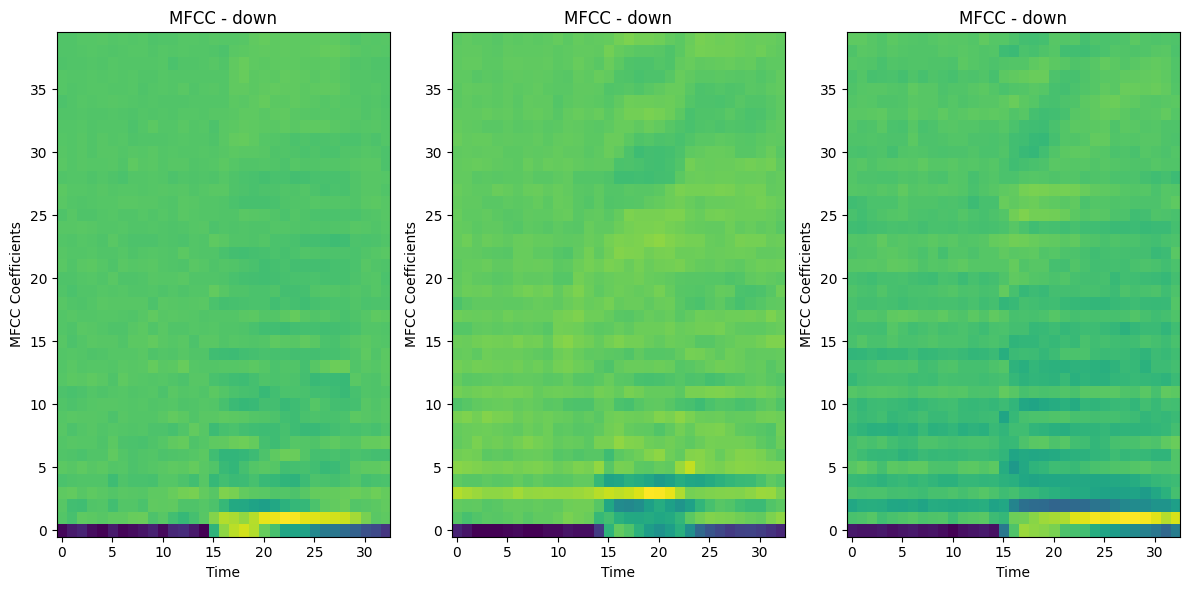

In [4]:
# MFCC parameters
N_MFCC = 40
N_FFT = 1024
HOP_LENGTH = 500
N_MELS = 64

mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_sr,
    n_mfcc=N_MFCC,
    melkwargs={"n_fft": N_FFT, "hop_length": HOP_LENGTH, "n_mels": N_MELS}
)

# Visualize MFCCs for a few samples
plt.figure(figsize=(12, 6))
for i, idx in enumerate(train_indices[:3]):
    waveform, sr, label, *_ = train_set[idx]
    mfcc = mfcc_transform(waveform)
    plt.subplot(1, 3, i+1)
    plt.imshow(mfcc[0].detach().numpy(), aspect='auto', origin='lower')
    plt.title(f"MFCC - {label}")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()



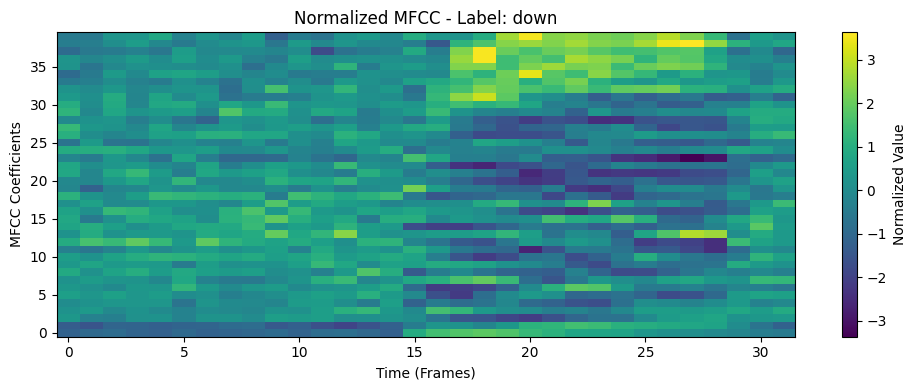

In [5]:
# Set max sequence length manually

MAX_SEQ_LEN = 32

# Compute mean and std for normalization (on training set)
all_feats = []
for idx in train_indices[:1000]:  # Use a subset for speed
    waveform, _, label, *_ = train_set[idx]
    mfcc = mfcc_transform(waveform)[0].T
    if mfcc.shape[0] < MAX_SEQ_LEN:
        pad = torch.zeros(MAX_SEQ_LEN - mfcc.shape[0], mfcc.shape[1])
        mfcc = torch.cat([mfcc, pad], dim=0)
    else:
        mfcc = mfcc[:MAX_SEQ_LEN, :]
    all_feats.append(mfcc)
all_feats = torch.stack(all_feats)
mean = all_feats.mean(dim=(0, 1))
std = all_feats.std(dim=(0, 1))

# Custom dataset class
class SpeechCommandsDataset(Dataset):
    def __init__(self, base_dataset, indices, mfcc_transform, max_seq_len, class_list, mean=None, std=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.mfcc_transform = mfcc_transform
        self.max_seq_len = max_seq_len
        self.class_to_idx = {c: i for i, c in enumerate(class_list)}
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        waveform, _, label, *_ = self.base_dataset[idx]
        mfcc = self.mfcc_transform(waveform)[0].T  # (time, n_mfcc)
        if mfcc.shape[0] < self.max_seq_len:
            pad = torch.zeros(self.max_seq_len - mfcc.shape[0], mfcc.shape[1])
            mfcc = torch.cat([mfcc, pad], dim=0)
        else:
            mfcc = mfcc[:self.max_seq_len, :]
        if self.mean is not None and self.std is not None:
            mfcc = (mfcc - self.mean) / self.std
        return mfcc, self.class_to_idx[label]

# Create datasets with fixed MAX_SEQ_LEN = 32
train_ds = SpeechCommandsDataset(train_set, train_indices, mfcc_transform, MAX_SEQ_LEN, CLASSES, mean, std)
val_ds = SpeechCommandsDataset(val_set, val_indices, mfcc_transform, MAX_SEQ_LEN, CLASSES, mean, std)
test_ds = SpeechCommandsDataset(test_set, test_indices, mfcc_transform, MAX_SEQ_LEN, CLASSES, mean, std)

# Collate function
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs)
    ys = torch.tensor(ys)
    return xs, ys

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Example visualization of normalized MFCC
mfcc_feat, label_idx = train_ds[0]
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_feat.T.numpy(), aspect='auto', origin='lower')
plt.title(f"Normalized MFCC - Label: {CLASSES[label_idx]}")
plt.xlabel("Time (Frames)")
plt.ylabel("MFCC Coefficients")
plt.colorbar(label="Normalized Value")
plt.tight_layout()
plt.show()


Epoch 1: Train Loss=1.2096, Val Loss=0.5824, Train Acc=0.5600, Val Acc=0.7861
Epoch 2: Train Loss=0.4722, Val Loss=0.3770, Train Acc=0.8454, Val Acc=0.8787
Epoch 3: Train Loss=0.3199, Val Loss=0.3248, Train Acc=0.8984, Val Acc=0.8974
Epoch 4: Train Loss=0.2337, Val Loss=0.2852, Train Acc=0.9254, Val Acc=0.9136
Epoch 5: Train Loss=0.1899, Val Loss=0.2518, Train Acc=0.9384, Val Acc=0.9220
Epoch 6: Train Loss=0.1633, Val Loss=0.2557, Train Acc=0.9478, Val Acc=0.9211
Epoch 7: Train Loss=0.1372, Val Loss=0.2654, Train Acc=0.9553, Val Acc=0.9249
Epoch 8: Train Loss=0.1219, Val Loss=0.2348, Train Acc=0.9601, Val Acc=0.9319
Epoch 9: Train Loss=0.1030, Val Loss=0.2572, Train Acc=0.9660, Val Acc=0.9317
Epoch 10: Train Loss=0.1001, Val Loss=0.2607, Train Acc=0.9680, Val Acc=0.9306


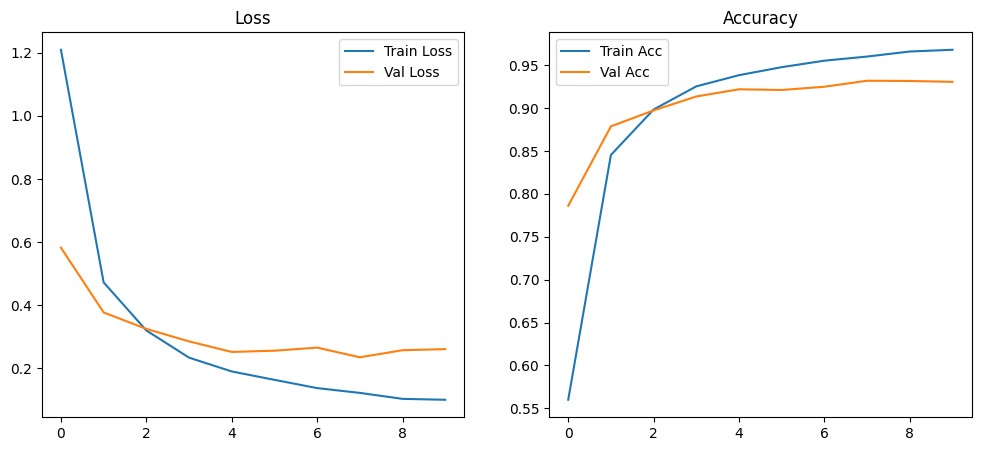

Test Loss: 0.3422, Test Accuracy: 0.9136


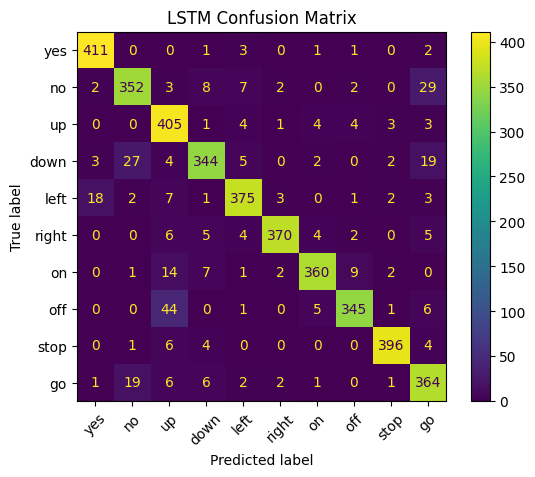

              precision    recall  f1-score   support

         yes       0.94      0.98      0.96       419
          no       0.88      0.87      0.87       405
          up       0.82      0.95      0.88       425
        down       0.91      0.85      0.88       406
        left       0.93      0.91      0.92       412
       right       0.97      0.93      0.95       396
          on       0.95      0.91      0.93       396
         off       0.95      0.86      0.90       402
        stop       0.97      0.96      0.97       411
          go       0.84      0.91      0.87       402

    accuracy                           0.91      4074
   macro avg       0.92      0.91      0.91      4074
weighted avg       0.92      0.91      0.91      4074



In [7]:
import os
import numpy as np
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

input_dim = N_MFCC
hidden_dim = 128
output_dim = len(CLASSES)
num_layers = 2
num_epochs = 10

# Model and optimizer
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, bidirectional=True, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
    def forward(self, x):
        x = x.to(DEVICE)
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

lstm_model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers=2, bidirectional=True, dropout=0.5).to(DEVICE)
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training and validation loops
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, count = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        _, preds = torch.max(out, 1)
        correct += (preds == y).sum().item()
        count += x.size(0)
    return total_loss / count, correct / count

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, count = 0.0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            count += x.size(0)
    return total_loss / count, correct / count

# Train model
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(num_epochs):
    tr_loss, tr_acc = train_epoch(lstm_model, train_loader, criterion, optimizer)
    va_loss, va_acc = eval_epoch(lstm_model, val_loader, criterion)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)
    print(f"Epoch {epoch+1}: Train Loss={tr_loss:.4f}, Val Loss={va_loss:.4f}, Train Acc={tr_acc:.4f}, Val Acc={va_acc:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Evaluate on test set
test_loss, test_acc = eval_epoch(lstm_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Confusion matrix and classification report
all_preds, all_labels = [], []
lstm_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        outputs = lstm_model(x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
disp.plot(xticks_rotation=45)
plt.title("LSTM Confusion Matrix")
plt.show()
print(classification_report(all_labels, all_preds, target_names=CLASSES))
